In [ ]:
{
 "cells": [],
 "metadata": {},
 "nbformat": 4,
 "nbformat_minor": 5
}


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3

db_path = "../data/sensor_data.db"
conn = sqlite3.connect(db_path)
df = pd.read_sql_query("SELECT * FROM sensors", conn)
conn.close()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
print(df.head())

                               asset_id  temperature  vibration          rpm  \
timestamp                                                                      
2025-08-27 21:42:08.972199  machine_001    60.248357  -0.067849  1517.414312   
2025-08-27 21:42:09.972199  machine_001    59.940868  -0.010551  1514.166180   
2025-08-27 21:42:10.972199  machine_001    60.343844  -0.019749  1453.174008   
2025-08-27 21:42:11.972199  machine_001    60.791515   0.071006  1528.979211   
2025-08-27 21:42:12.972199  machine_001    59.922923   0.199633  1425.495866   

                              pressure  
timestamp                               
2025-08-27 21:42:08.972199   96.038856  
2025-08-27 21:42:09.972199   97.890029  
2025-08-27 21:42:10.972199   98.825943  
2025-08-27 21:42:11.972199  100.299338  
2025-08-27 21:42:12.972199  102.048325  


In [2]:
# Only numeric columns for resampling
numeric_cols = df.select_dtypes(include='number')
df_resampled = numeric_cols.resample('10s').mean().interpolate()
print("Resampled shape:", df_resampled.shape)

# Optional: keep non-numeric columns like 'asset_id'
non_numeric_cols = df.select_dtypes(exclude='number').resample('10s').ffill()
df_resampled = pd.concat([df_resampled, non_numeric_cols], axis=1)


Resampled shape: (1001, 4)


In [3]:
from scipy.stats.mstats import winsorize

for col in ['temperature', 'vibration', 'rpm', 'pressure']:
    if col in df_resampled.columns:
        df_resampled[col] = winsorize(df_resampled[col], limits=[0.01, 0.01])


In [4]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
import joblib

# Create directory
os.makedirs("../data/processed", exist_ok=True)

window_size = 60
df_features = df_resampled.copy()
for col in ['temperature', 'vibration', 'rpm', 'pressure']:
    df_features[f'{col}_mean'] = df_features[col].rolling(window=window_size).mean()
    df_features[f'{col}_std'] = df_features[col].rolling(window=window_size).std()
df_features['power'] = df_features['rpm'] * df_features['pressure'] / 1000
df_features.dropna(inplace=True)

# Normalize features
feature_cols = [col for col in df_features.columns if col not in ['timestamp', 'asset_id']]
scaler = StandardScaler()
df_features[feature_cols] = scaler.fit_transform(df_features[feature_cols])
joblib.dump(scaler, "../data/processed/scaler.joblib")  # Save in project root

processed_path = "../data/processed/features.csv"
df_features.to_csv(processed_path)
print("Features saved to", processed_path)
print("Feature columns:", df_features.columns.tolist())
print("Scaler saved to ../data/processed/scaler.joblib")

Features saved to ../data/processed/features.csv
Feature columns: ['temperature', 'vibration', 'rpm', 'pressure', 'asset_id', 'temperature_mean', 'temperature_std', 'vibration_mean', 'vibration_std', 'rpm_mean', 'rpm_std', 'pressure_mean', 'pressure_std', 'power']
Scaler saved to ../data/processed/scaler.joblib


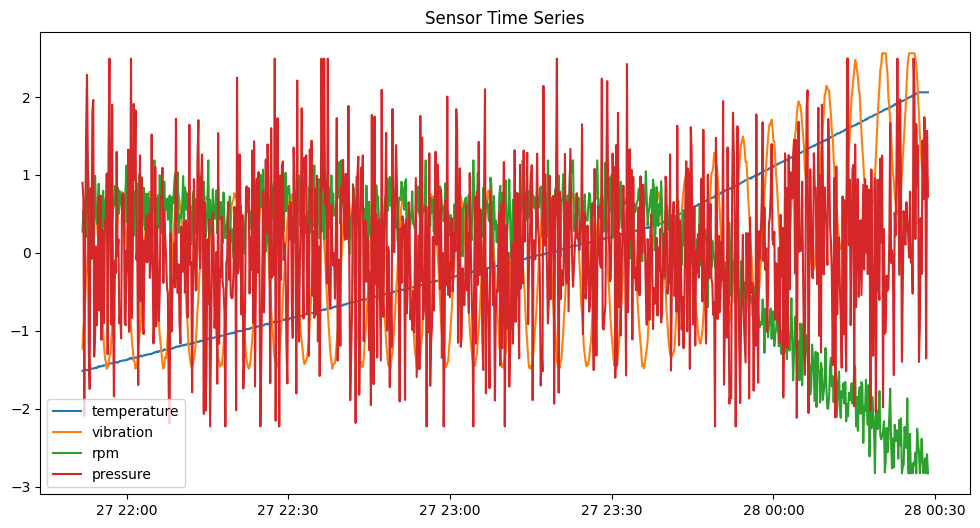

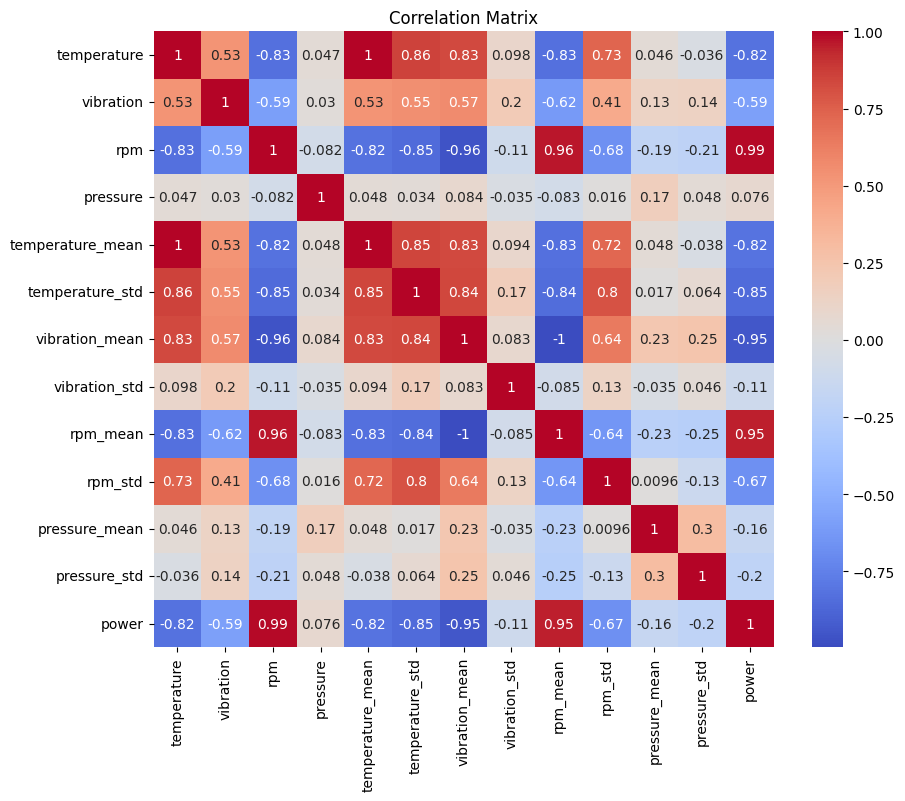

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Time series plot (numeric columns only)
plt.figure(figsize=(12, 6))
for col in ['temperature', 'vibration', 'rpm', 'pressure']:
    if col in df_features.columns:
        plt.plot(df_features.index, df_features[col], label=col)
plt.legend()
plt.title("Sensor Time Series")
plt.show()

# Correlation heatmap (numeric columns only)
numeric_cols = df_features.select_dtypes(include=np.number)
corr = numeric_cols.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [6]:
import numpy as np

def create_sequences(data, seq_len=128):
    X = []
    for i in range(len(data) - seq_len + 1):
        X.append(data[i:i+seq_len])
    return np.array(X)

feature_cols = [col for col in df_features.columns if col not in ['timestamp', 'asset_id']]
seq_data = df_features[feature_cols].values
sequences = create_sequences(seq_data, seq_len=128)
np.save("../data/processed/sequences.npy", sequences)
print("Sequences shape:", sequences.shape)

Sequences shape: (815, 128, 13)


18:46:00 - cmdstanpy - INFO - Chain [1] start processing
18:46:00 - cmdstanpy - INFO - Chain [1] done processing


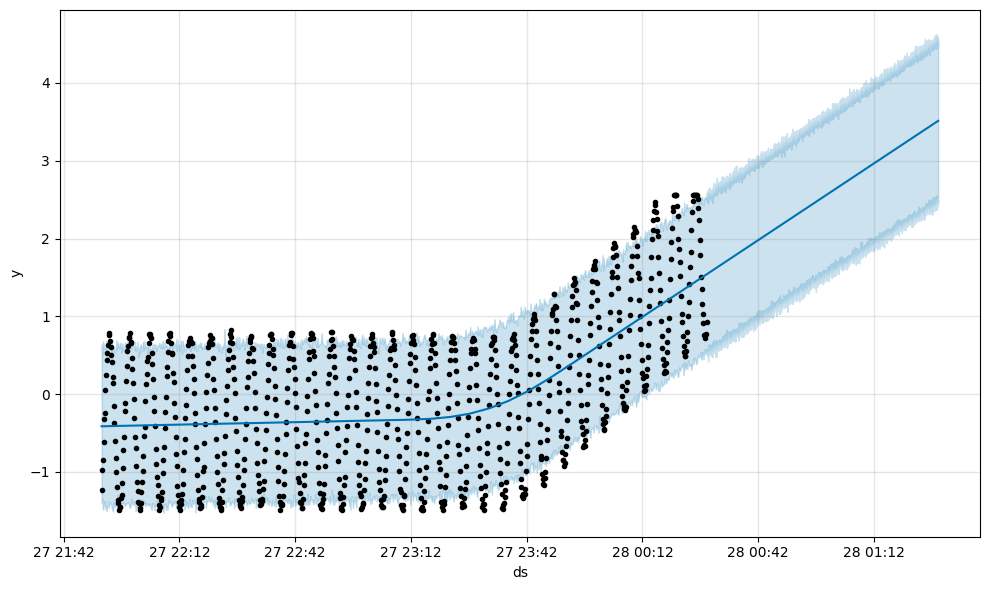

In [7]:
from prophet import Prophet

df_prophet = df_features.reset_index()[['timestamp', 'vibration']].rename(columns={'timestamp': 'ds', 'vibration': 'y'})
m = Prophet()
m.fit(df_prophet)
future = m.make_future_dataframe(periods=3600, freq='s')  # 1 hour forecast
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
m.plot(forecast)
plt.show()

In [8]:
feature_cols = [col for col in df_features.columns if col != 'asset_id']
n_features = len(feature_cols)
print("Number of features:", n_features)
from sklearn.preprocessing import MinMaxScaler

# Flatten sequences for scaler
n_samples, seq_len, n_features = sequences.shape
scaler = MinMaxScaler()
sequences_flat = sequences.reshape(-1, n_features)  # (n_samples*seq_len, n_features)
sequences_scaled_flat = scaler.fit_transform(sequences_flat)
sequences_scaled = sequences_scaled_flat.reshape(n_samples, seq_len, n_features)



Number of features: 13


D:\PROJECTS\pdmp_project\notebooks


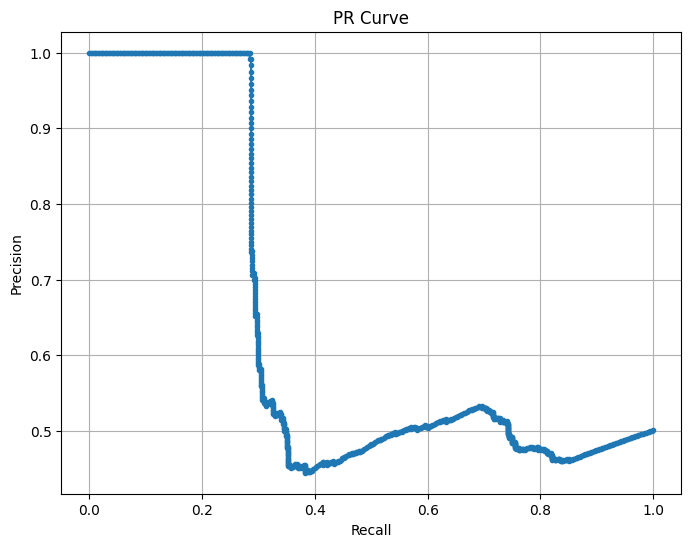

In [13]:
import torch
import sys
sys.path.append("../models")  # Path from notebook to models folder

from lstm_ae import LSTMAutoencoder
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import os
print(os.getcwd())

# Initialize model
model = LSTMAutoencoder(n_features)  # n_features from sequences
model.load_state_dict(torch.load("../lstm_ae_model.pth"))
model.eval()

# Use post-7000 sequences as test (simulate anomaly region)
test_seq = torch.from_numpy(sequences_scaled).float() 
with torch.no_grad():
    recon = model(test_seq)
    errors = torch.mean((recon - test_seq)**2, dim=[1,2]).numpy()

# Simulate labels: 0 = normal, 1 = anomaly (for PR curve)
labels = np.zeros(len(errors))
labels[int(len(errors)/2):] = 1  # Half normal, half anomalous

# Precision-Recall
precision, recall, thresholds = precision_recall_curve(labels, errors)
plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve")
plt.grid(True)
plt.show()


  0%|          | 0/1 [00:00<?, ?it/s]

D:\PROJECTS\pdmp_project\venv\Lib\site-packages\sklearn\linear_model\_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.899e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(


SHAP values shape: (1, 1664)


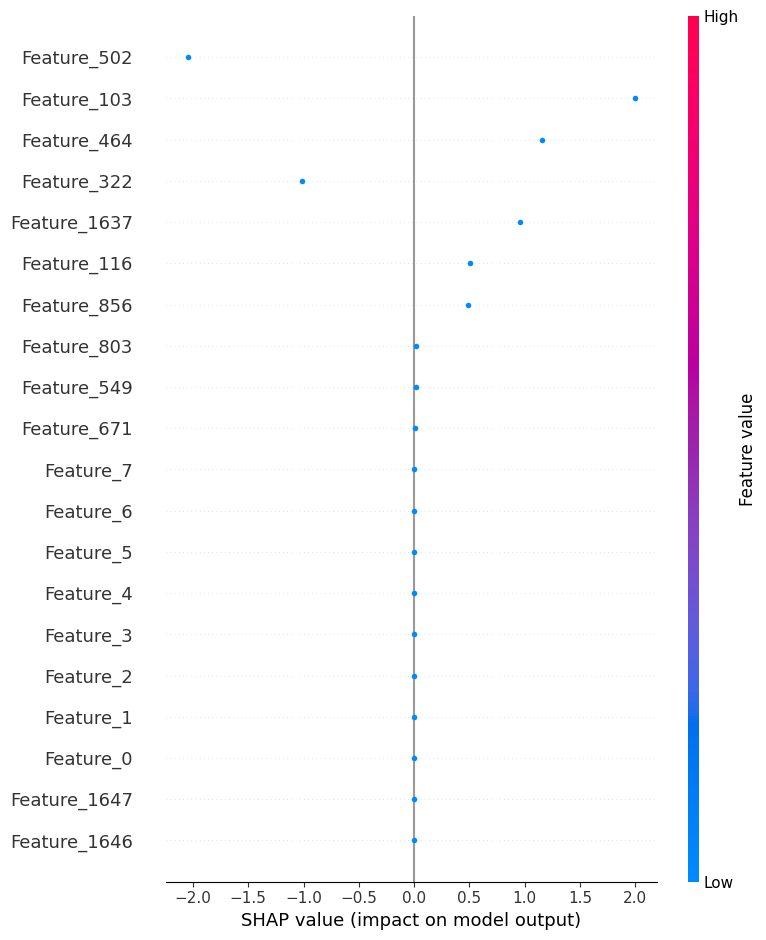

In [14]:
import shap
import torch
import numpy as np

# Wrapper to reshape input for LSTM
def model_wrapper(x_flat):
    seq_len = 128
    n_features = 13
    x = torch.from_numpy(x_flat.reshape(-1, seq_len, n_features)).float()
    with torch.no_grad():
        y = model(x)
        errors = torch.mean((y - x)**2, dim=[1, 2])
    return errors.numpy()

# Load model
model = LSTMAutoencoder(n_features=13)
model.load_state_dict(torch.load("../lstm_ae_model.pth"))
model.eval()

# Load sequences
sequences_scaled = np.load("../data/processed/sequences.npy").astype(np.float32)
background = sequences_scaled[:5].reshape(5, -1)  # Reduced to 5 samples
test_instance = sequences_scaled[-1:].reshape(1, -1)

# Initialize SHAP explainer with fewer samples
explainer = shap.KernelExplainer(model_wrapper, background, n_samples=50)  # Limit samples
shap_values = explainer.shap_values(test_instance, nsamples=50)
print("SHAP values shape:", np.array(shap_values).shape)

# Plot feature importance
shap.summary_plot(shap_values, features=test_instance, feature_names=[f"Feature_{i}" for i in range(128*13)])

In [15]:
from statsmodels.tsa.stattools import grangercausalitytests

max_lag = 5
test_result = grangercausalitytests(df_features[['temperature', 'vibration']], maxlag=max_lag)
print(test_result)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5375  , p=0.4637  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=0.5392  , p=0.4628  , df=1
likelihood ratio test: chi2=0.5390  , p=0.4628  , df=1
parameter F test:         F=0.5375  , p=0.4637  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8249  , p=0.4386  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=1.6586  , p=0.4364  , df=2
likelihood ratio test: chi2=1.6571  , p=0.4367  , df=2
parameter F test:         F=0.8249  , p=0.4386  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9473  , p=0.4171  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=2.8633  , p=0.4132  , df=3
likelihood ratio test: chi2=2.8590  , p=0.4139  , df=3
parameter F test:         F=0.9473  , p=0.4171  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7860  , p=0.5343  

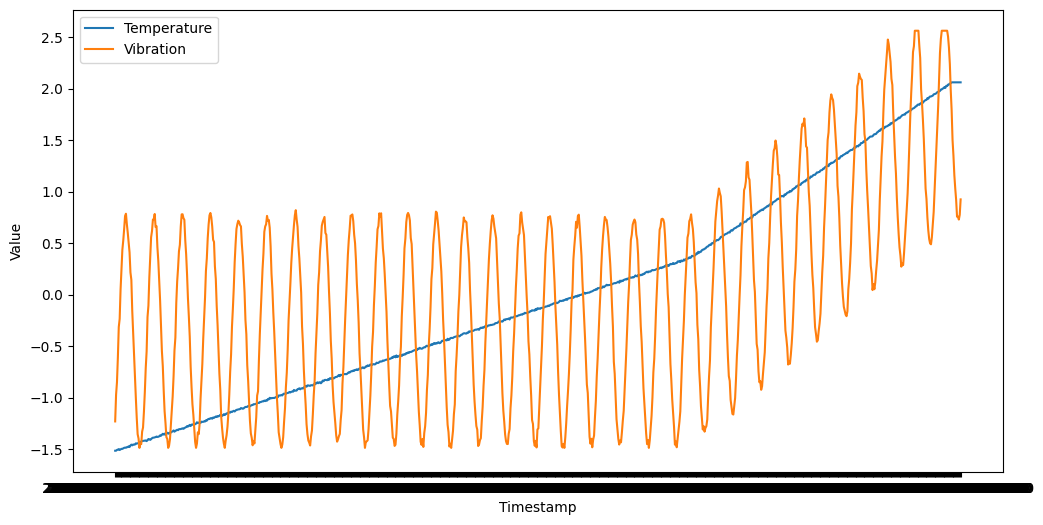

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/features.csv")
plt.figure(figsize=(12, 6))
plt.plot(df['timestamp'], df['temperature'], label='Temperature')
plt.plot(df['timestamp'], df['vibration'], label='Vibration')
# Add anomaly points from dashboard (replace with your anomaly_indices)
anomaly_indices = []  # Copy from dashboard output
if anomaly_indices:
    plt.scatter(df['timestamp'].iloc[anomaly_indices], df['temperature'].iloc[anomaly_indices], c='red', label='Anomalies')
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.legend()
plt.show()

In [26]:
import pandas as pd

df_raw = pd.read_csv("../data/raw/synthetic_sensor_data.csv")
print(df_raw.iloc[750:820][['timestamp', 'temperature', 'vibration']])

               timestamp  temperature  vibration
750  2023-01-01 12:30:00    65.383834   0.532549
751  2023-01-01 12:31:00    63.241577   0.609958
752  2023-01-01 12:32:00    65.120634   0.275150
753  2023-01-01 12:33:00    75.268209   0.387490
754  2023-01-01 12:34:00    65.253006   0.441926
..                   ...          ...        ...
815  2023-01-01 13:35:00    62.572198   0.466091
816  2023-01-01 13:36:00    71.335251   0.509601
817  2023-01-01 13:37:00    74.448154   0.520207
818  2023-01-01 13:38:00    70.411420   0.499580
819  2023-01-01 13:39:00    75.327402   0.670536

[70 rows x 3 columns]


In [29]:

model = LSTMAutoencoder(n_features=13)
model.load_state_dict(torch.load("../lstm_ae_model.pth"))
model.eval()

seq_tensor = torch.tensor(sequences[756:757]).float()  # Single sequence
with torch.no_grad():
    recon = model(seq_tensor)
    error = torch.mean((recon - seq_tensor)**2).item()
print(f"Error for sequence 756: {error}, Anomaly: {error > 0.7363}")

Error for sequence 756: 0.742641031742096, Anomaly: True


In [30]:
import numpy as np
import joblib
import torch
from lstm_ae import LSTMAutoencoder

sequences = np.load("../data/processed/sequences.npy")
scaler = joblib.load("../data/processed/scaler.joblib")
model = LSTMAutoencoder(n_features=13)
model.load_state_dict(torch.load("../lstm_ae_model.pth"))
model.eval()

seq_756 = sequences[756]  # Shape (128, 13)
seq_tensor = torch.tensor(seq_756).float().unsqueeze(0)
with torch.no_grad():
    recon = model(seq_tensor)
    error = torch.mean((recon - seq_tensor)**2).item()
print(f"Error for sequence 756: {error}, Anomaly: {error > 0.7363}")
print("First few normalized values:", seq_756[:5, :4])  # Check for outliers

Error for sequence 756: 0.742641031742096, Anomaly: True
First few normalized values: [[ 1.03404804  0.12611032 -0.92035972  0.66650982]
 [ 1.03551986  0.24481285 -0.59848578  1.67537949]
 [ 1.05052382  0.4409053  -0.73196361 -0.10695889]
 [ 1.05125957  0.76418586 -1.28330097  0.58233081]
 [ 1.05867328  0.91246816 -0.72098229 -0.22105326]]


In [31]:
import numpy as np

np.random.seed(42)  # Match simulate_ingestion.py
anomaly_injected = np.random.choice(10000, size=500, replace=False)
print("Injected anomaly indices near 756-814:", anomaly_injected[(anomaly_injected >= 750) & (anomaly_injected <= 814)])

Injected anomaly indices near 756-814: [799 764 765 794 795]
